<a href="https://colab.research.google.com/github/JoseNunes24/ExpeditionAnalysis/blob/master/Expedition_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload Necessary Files

##Import Main files

In [0]:
url_1 = 'https://raw.githubusercontent.com/JoseNunes24/ExpeditionAnalysis/master/2017.csv'

url_2 = 'https://raw.githubusercontent.com/JoseNunes24/ExpeditionAnalysis/master/2018.csv'


## Import Auxiliar tables

In [0]:
url_country = 'https://raw.githubusercontent.com/JoseNunes24/ExpeditionAnalysis/master/CCMasked.csv'

url_mm = 'https://raw.githubusercontent.com/JoseNunes24/ExpeditionAnalysis/master/MMMasked.csv'



## Add monthly data

To add month data, it can be uploaded from here. For the purpose of this notebook though, it won't be used, and the appropriate code to deal with the month data will be commented out

In [0]:
#from google.colab import files
#uploadedMonth = files.upload()

## Import libraries and data

In [0]:
'''
When adding data, the month data is df2, as it will need to be worked upon,
  but for the purpose of this notebook, I will work with the years 2017 and
  2018, so they will be saved on that dataframe

df1 would be the data already worked upon, the past years and months, where 
  we would append df2 after it's data is cleaned
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from datetime import datetime, timedelta
from itertools import islice

# Monthly data
#df2 = pd.read_csv(io.BytesIO(uploadedMonth['ld0.csv']), encoding='latin-1', sep=';') 

#Main file, add the 2017 and 2018 in one dataframe
df2 = pd.read_csv(url_1, encoding='latin-1', sep=';')

df2 = df2.append(pd.read_csv(url_2, encoding='latin-1', sep=';'), 
                 ignore_index=True,
                 sort=False)

# Country Table
dfCountry = pd.read_csv(url_country, encoding='latin-1', sep=';') 

# Material master
dfMaterial = pd.read_csv(url_mm, encoding='latin-1', sep=';')

# Create a table for SGL Brand
dfLbrand = pd.DataFrame({'LBrand': [5, 10, 20, 25, 40], 
                           'Marketing Label': ['Elven', 'SpecOps', 
                                               'FF', 'WOK', 'ZZTOP']})

# Manipulating Data

## Cleaning the data

### Columns to appropriate type

In [0]:
df2['Qtty'] = df2['Qtty'].astype(str)
df2['Qtty'] = df2['Qtty'].str.replace(' ', '')

df2['Qtty'] = df2['Qtty'].astype(int)

# Sometimes the date may come in 12 hour instead of 24 hour, this can be 
#  improved further (nothing other than an hour value should be in the data, 
#  but a way to prevent that could be written here)
def transform_time (times):
  try:
    return (pd.to_datetime(times, format = ('%H:%M:%S')).dt.time)
  except:
    return (pd.to_datetime(times).strftime('%H:%M:%S'))
   
df2['Time'] = df2.apply(lambda x: 
                                transform_time(x['Time']), axis=1)

# The previous function may not return the same type of object, so this makes 
#  sure it is the right type of time value 
df2['Time'] = pd.to_datetime(
    df2['Time'], format = ('%H:%M:%S')).dt.time

df2['Planned Date'] = (
    pd.to_datetime(df2['Planned Date'], dayfirst=True))

df2['Product'] =  df2['Product'].astype(str)

df2['Client ID'] =  df2['Client ID'].astype(str).replace(
    '\.0', '', regex=True)

# Remove zeros from number if they somehow appear
df2['Unit'] =  df2['Unit'].astype(str).replace('\.0', '', regex=True)

df2['Product'] =  df2['Product'].astype(str).replace('\.0', '', regex=True)

dfMaterial['Product'] = dfMaterial['Product'].astype(str)

dfLbrand['LBrand'] = dfLbrand['LBrand'].astype(str)


### Real Shipment Date

In [0]:
'''Transform and see if the date is correct

Shipments from before 8AM will be considered from the past day 
  (a new day is considered to be from 8AM, beginning the first shift at that time)

It gets the time, checks if its before 8AM and takes a day from 
  the Planned Date
  
'''

first_shift_time = pd.to_datetime('08:00:00', format = '%H:%M:%S').time()

df2.loc[df2['Time'] < first_shift_time, ['Planned Date']] = (
  df2['Planned Date'] - timedelta(days=1))

### Checking the type of shipment

In [0]:
'''Verifying type of Expedition

  The type of Expedition can be
    
    SP -> Last 4 digits can be "0000" or end with a number in the last digit,
          Ex: "xxxxxx0008"
    EX -> Excluding the last digit, the other 3 penultimate digits have to be
          something other than "0000"
          Ex: "xxxxxx039x"

'''

def type_of_shipment (articleNumber) :
  
  if articleNumber[-4:-1] == '000'  :
    return 'SP'
  else:
    return 'EX'

df2['Type of shipment'] = df2.apply(lambda x: type_of_shipment(x['Product']),
                                    axis=1)

### Merging tables

In [0]:
'''Merging The tables for necessary data
  
  Some information about the products shipped are in different tables,
  specifically:

  - The info about the Marketing Label is from the LBrand table
  - The info about the Country Label is from the CCMasked table
  - Some clients have exceptions, which will be dealt with

'''
dfMaterial['LBrand'] = dfMaterial['LBrand'].astype(str)

# Get the LBrand code of the product
df2 = pd.merge(df2,dfMaterial[['Product','LBrand']], on='Product',
               how='left')

dfLbrand['LBrand'] = dfLbrand['LBrand'].astype(str)

# Get the Label from the LBrand code
df2 = pd.merge(df2,dfLbrand, on='LBrand',how='left')

df2['LBrand'] = df2['LBrand'].astype(str)

# Get the Country Label
df2 = pd.merge(df2,dfCountry[['Country','Label']], on='Country',
               how='left')

### Exceptions to Labels

In [0]:
'''Exceptions to Labels
   
   Some clients, countries and markets have certain types of exceptions
   to labels

'''

# Marketing Label exceptions

clients_ID_Exceptions = set(['3048620', '3128023', '2875903', '2882122'])
country_Exception = 'CI'
markets_Exceptions = set(['Tolkien', 'H.O.B.B.'])

def type_of_label (businessID, MarketingLabel, 
                   shipment_type, country, market): 

  if (businessID in (clients_ID_Exceptions) or shipment_type == 'EX' or 
      country == country_Exception or market in markets_Exceptions): 
    return 'Nada'
  else:
    return MarketingLabel
    
df2['Country'] = df2['Country'].astype(str)
df2['Client ID'] = df2['Client ID'].astype(str)
df2['Label'] = df2['Label'].astype(str)

df2['Marketing Label'] = df2.apply(lambda x: 
                                   type_of_label(
                                       x['Client ID'],
                                       x['Marketing Label'], 
                                       x['Type of shipment'], 
                                       x['Country'], 
                                       x['Label']),
                                   axis=1)

In [0]:
# Country Label exceptions

clients_ID_Exceptions_Country = set(['3048620', '3128023', '2882122',
                                     '3149700', '2880583'])

def country_type_of_label (businessID, shipment_type, market): 

  if (businessID in (clients_ID_Exceptions) or shipment_type == 'EX'):   
    return 'Nada'
  else:
    return market

df2['Label'] = df2.apply(lambda x: country_type_of_label (
                                       x['Client ID'],
                                       x['Type of shipment'], 
                                       x['Label']),
                                   axis=1)

### Append the monthly Data to existing Database

In [0]:
#df1.append(d2, ignore_index=True, sort=False)

# Analysing Data

## Extracting Valuable Data

In [0]:
total_products_shipped = total_number_of_shipments = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month')])['Qtty'].sum()

total_number_of_shipments = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month')])['Unit'].nunique()

total_number_of_products = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month')])['Unit'].count()

total_number_of_products_type = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'), 
     df2['Type of shipment']])['Unit'].count()

total_number_of_shipments_type = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'),
     df2['Type of shipment']])['Unit'].nunique()

total_labels_Marketing = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'), 
     df2['Marketing Label']])['Qtty'].sum()

total_labels_Country = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'),
     df2['Label']])['Qtty'].sum()

total_number_of_shipments_city = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'),
     df2['City']])['Unit'].nunique()

total_number_of_products_city = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'),
     df2['City']])['Unit'].count()



## Total shipped

In [0]:
# Transform group by object to dataframe
total_products_shipped =pd.DataFrame(
    total_products_shipped.reset_index(name='Quantity').pivot_table(
        index=['Year','Month'],  
        values='Quantity', 
        aggfunc='sum', 
        fill_value=0).to_records())

# Set index as Year/Month to be easier to plot
total_products_shipped = total_products_shipped.set_index(
    pd.to_datetime(total_products_shipped[['Year','Month']].assign(day=1))
    ).drop(['Year', 'Month'], axis=1)


This part gets the country code and creates columns for the full name of the country and the continent it belongs to, to plot further down

In [0]:
'''Library of countries

  From 2 ISO country code, it transforms into full name, 3 ISO code, and more
  The pycountry_convert is to return the continent from the name'''
  
!pip install pycountry
!pip install pycountry_convert

In [0]:
# Transform group by object to dataframe BY country
total_products_shipped_Country = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'),
     df2['Country']])['Qtty'].sum()

total_products_shipped_Country = pd.DataFrame((total_products_shipped_Country.reset_index()).to_records())

# Set index as Year/Month to be easier to plot
total_products_shipped_Country = total_products_shipped_Country.set_index(
    pd.to_datetime(total_products_shipped_Country[['Year','Month']].assign(day=1))
    ).drop(['Year', 'Month'], axis=1)

total_products_shipped_Country.drop(columns= {'index'}, axis=1, inplace=True)

#Transform ISO Code into Country name
import pycountry

input_countries = total_products_shipped_Country['Country']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.name

total_products_shipped_Country['Country Name'] = [countries.get(country, 'Unknown Country') for country in input_countries]

# Continent

import pycountry_convert as pc

continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}

total_products_shipped_Country['Continent'] = [continents[pc.country_alpha2_to_continent_code(country)] for country in input_countries]

total_products_shipped_Country.rename(columns={'Qtty': 'Quantity'}, 
                                      inplace=True)

## SP expeditions 

In [0]:
# Table with only SP type shipments
df_SP = df2[df2['Type of shipment'] == 'SP']

# Last month
most_recent_date = df_SP['Planned Date'].max()

# Group the shipments by date
nr_shipments_SP = df_SP.groupby(
    [df_SP['Planned Date'].dt.year.rename('Year'), 
     df_SP['Planned Date'].dt.month.rename('Month')])['Unit'].nunique()

nr_products_SP = df_SP.groupby(
    [df_SP['Planned Date'].dt.year.rename('Year'), 
     df_SP['Planned Date'].dt.month.rename('Month')])['Unit'].count()

# EX vs SP Share
count_total = df2['Qtty'].sum()
count_SP = df_SP['Qtty'].sum()

shareSP = (1-(count_total - count_SP) / count_total) * 100

shareEX = 100 - shareSP

df_shares = pd.DataFrame({'Percentage':[shareEX, shareSP]}, index = 
                         ['EX', 'SP'])

# Average number of different products by shipment and type, only SP is
#  considered for this KPI
complexity = ( nr_products_SP / nr_shipments_SP)

# Last month share
last_df2 = df2[df2['Planned Date'].dt.month == most_recent_date.month]
last_df_SP = df_SP[df_SP['Planned Date'].dt.month == most_recent_date.month]

# EX vs SP Share
count_total_month = last_df2['Qtty'].sum()
count_SP_month = last_df_SP['Qtty'].sum()

shareSPMonth = (1-(count_total_month - count_SP_month) / count_total_month) * 100

shareEXMonth = 100 - shareSP

df_shares_month = pd.DataFrame({'Percentage':[shareEXMonth, shareSPMonth]}, 
                               index = ['EX', 'SP'])

## City Complexity

In [0]:
# City Complexity of last month
df_city_complex = \
  df_SP[df_SP['Planned Date'].dt.month == most_recent_date.month]

# Total nr. of products / total shipments 
city_complexity = (
      df_city_complex.groupby([df_SP['Planned Date'].dt.month.rename('Month'),
                               df2['City']])['Unit'].count() 
      / df_city_complex.groupby([df_SP['Planned Date'].dt.month.rename('Month'),
                                 df2['City']])['Unit'].nunique() 
  )

# Count of UTs, so i can select those bigger than 5 shipments, and to display
#  the number in the chart below
ut_count = df_city_complex.groupby([df_SP['Planned Date'].dt.month.rename('Month'),
                                 df2['City']])['Unit'].nunique() 

ut_count = pd.DataFrame(
    (ut_count.reset_index()).to_records())

# Transform to dataframe
city_complexity = pd.DataFrame(
    (city_complexity.reset_index()).to_records())

city_complexity = city_complexity.set_index('City')

city_complexity = city_complexity.sort_values(by = ['Unit'], 
                                              ascending=False)


city_complexity['Unit'] = city_complexity['Unit'].round(2)

city_complexity.rename(columns={'Unit': 'Complexity'}, inplace=True)

# Merge with the count of vehicles
city_complexity= pd.merge(city_complexity, ut_count[['City', 'Unit']], 
                          how='left', 
                          on='City')

city_complexity['Unit'] = city_complexity['Unit'].astype(int)

# Top 10
city_complexity = city_complexity[city_complexity['Unit'] > 5].nlargest(10, 'Complexity')

city_complexity.rename(columns={'Unit': 'Count'}, inplace=True)

city_complexity = city_complexity.sort_values(by = ['Complexity'], 
                                              ascending=False)

In [0]:
# Transform complexity GroupBy Object to dataframe
complexity = (complexity.reset_index(name='Complexity').pivot_table(
    index=['Year','Month'],  values='Complexity', aggfunc='sum', fill_value=0))

complexity = pd.DataFrame(complexity.to_records())

complexity['Date'] = pd.to_datetime(complexity[['Year','Month']].assign(day=1))

complexity = complexity.drop(['Year', 'Month'], axis=1)


### Get Country Labels to a dataframe

In [0]:
# Transform Market (Country) Labels GroupBy Object to dataframe
total_labels_Country = pd.DataFrame((total_labels_Country.reset_index()).to_records())

total_labels_Country = total_labels_Country.set_index(
    pd.to_datetime(total_labels_Country[['Year','Month']].assign(day=1)))

total_labels_Country = total_labels_Country.drop(['Year', 'Month', 'index'], axis=1)

### Get Marketing Labels to a dataframe

In [0]:
# Transform marketing Labels GroupBy Object to dataframe
total_labels_Marketing = pd.DataFrame(
    (total_labels_Marketing.reset_index()).to_records())

total_labels_Marketing = total_labels_Marketing.set_index(
    pd.to_datetime(total_labels_Marketing[['Year','Month']].assign(day=1)))

total_labels_Marketing = total_labels_Marketing.drop(['Year', 'Month', 'index'], 
                                                     axis=1)


## Get number of label rolls used

Labels come in rolls, and each have a different quantity

In [0]:
# Transformar em rolos
def rolls(typeR, quantity):
  if typeR =='FF':
    return quantity/777
  elif typeR == 'WOK':
   return quantity/1234
  elif typeR == 'ZZTOP':
   return quantity/3457
  elif typeR == 'H.O.B.B.':
   return quantity/2084
  elif typeR == 'Tolkien':
   return quantity/3333
  else:
   return quantity/5000

total_labels_Marketing['Marketing Rolls'] = total_labels_Marketing.apply(lambda x:
                                                                         rolls(x['Marketing Label'],
                                                                               x['Qtty']),
                                                                         axis=1)

total_labels_Country['Country Rolls'] = total_labels_Country.apply(lambda x:
                                                                rolls(x['Label'],
                                                                      x['Qtty']),
                                                                axis=1)

In [0]:
# Transform tables into pivot tables to plot the data
total_labels_Marketing = total_labels_Marketing.reset_index().pivot_table(
    index=['index'], columns='Marketing Label', values='Marketing Rolls', aggfunc='sum')

total_labels_Country = total_labels_Country.reset_index().pivot_table(
    index=['index'], columns='Label', values='Country Rolls', aggfunc='sum')

## Plot data

In [0]:
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
import seaborn as sns
from matplotlib import pyplot
import statsmodels.api as sm
from pylab import rcParams

# Set already the correct format for date 
years = mdates.YearLocator()
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b') 
yearsFmt = mdates.DateFormatter('\n\n%Y')

sns.set_context("talk")

### Total Complexity

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


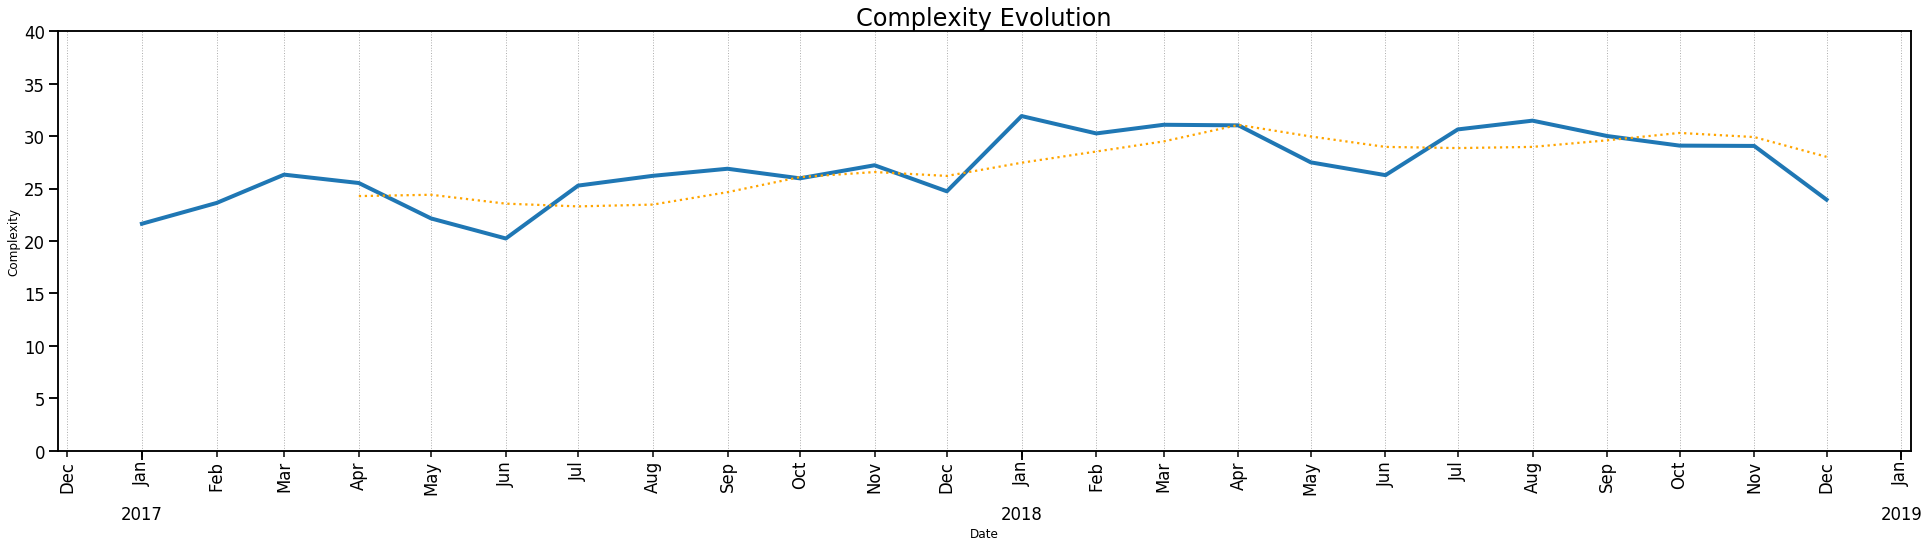

In [24]:
# Plot Complexity of MS shipments

fig = plt.figure(figsize=(27.16, 7.95))
ax = plt.axes()

x = complexity['Date']
y = complexity['Complexity']

ax.plot(x, y, linewidth=4)

# Create a Moving Average
complexity['MA'] = complexity['Complexity'].rolling(window=4,center=False).mean()

ax.plot(x, complexity['MA'], color='Orange', linestyle=':')

ax.set_xlabel('Date', fontsize='12')
ax.set_ylabel('Complexity', fontsize='12')
ax.set_title('Complexity Evolution', fontsize='24')

ax.set_xticks(x)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set_ylim(0,40)
ax.legend().remove()

# Set minor gridlines
ax.xaxis.grid(which="minor", linestyle=':', linewidth=1)

fig.tight_layout()
plt.show()

# Save the graphics. I commented these out
#fig.savefig('complexity.png', bbox_inches='tight')
#files.download('complexidade.png') 

### Complexity Analysis

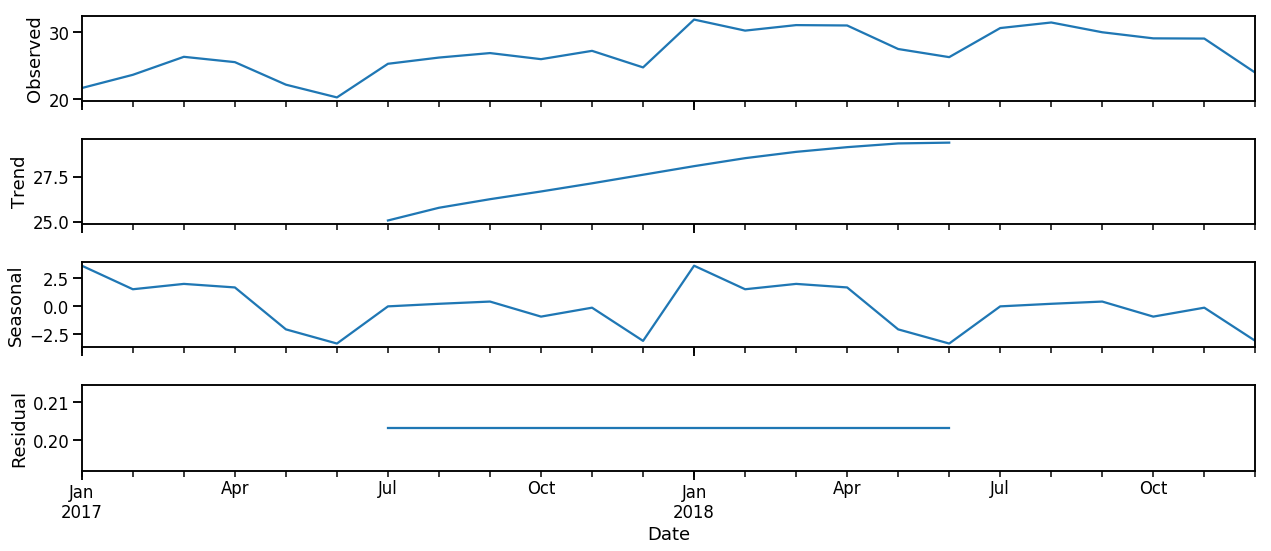

In [25]:
complex_trend = complexity.set_index(['Date'])

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(complex_trend['Complexity'], model='additive')
fig = decomposition.plot()
plt.show()

### Ex vs SP Share

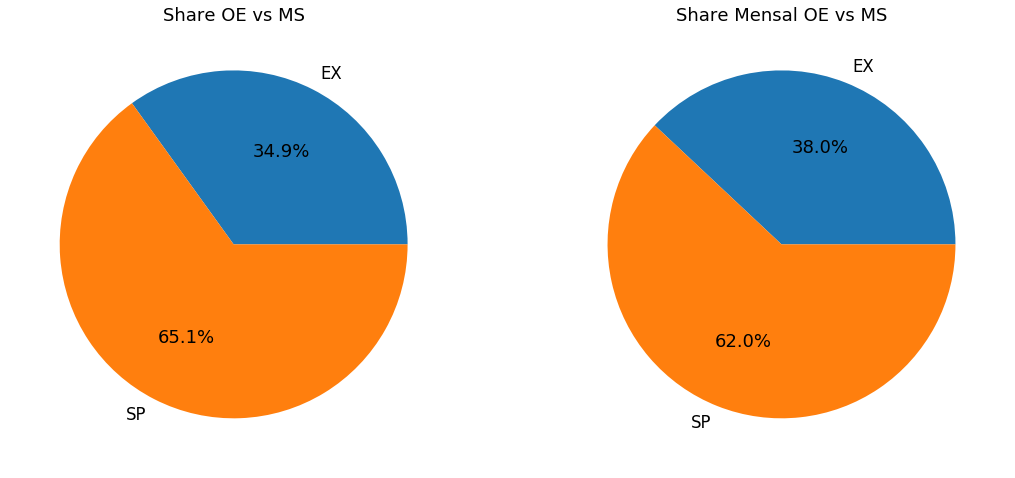

In [26]:
# Share

fig, axs = plt.subplots(1, 2)

x1 = df_shares['Percentage']
y1 = df_shares.index

# Valid only when importing monthly data
x2 = df_shares_month['Percentage']
y2 = df_shares_month.index

# A standard pie plot
axs[0].pie(x1, labels=y1, autopct='%1.1f%%')
axs[0].set_title('Share OE vs MS')
axs[1].pie(x2, labels=y2, autopct='%1.1f%%')
axs[1].set_title('Share Mensal OE vs MS')

plt.show()

# Save figure
#fig.savefig('share.png', bbox_inches='tight')
#files.download('share.png') 

### Total Marketing Label usage

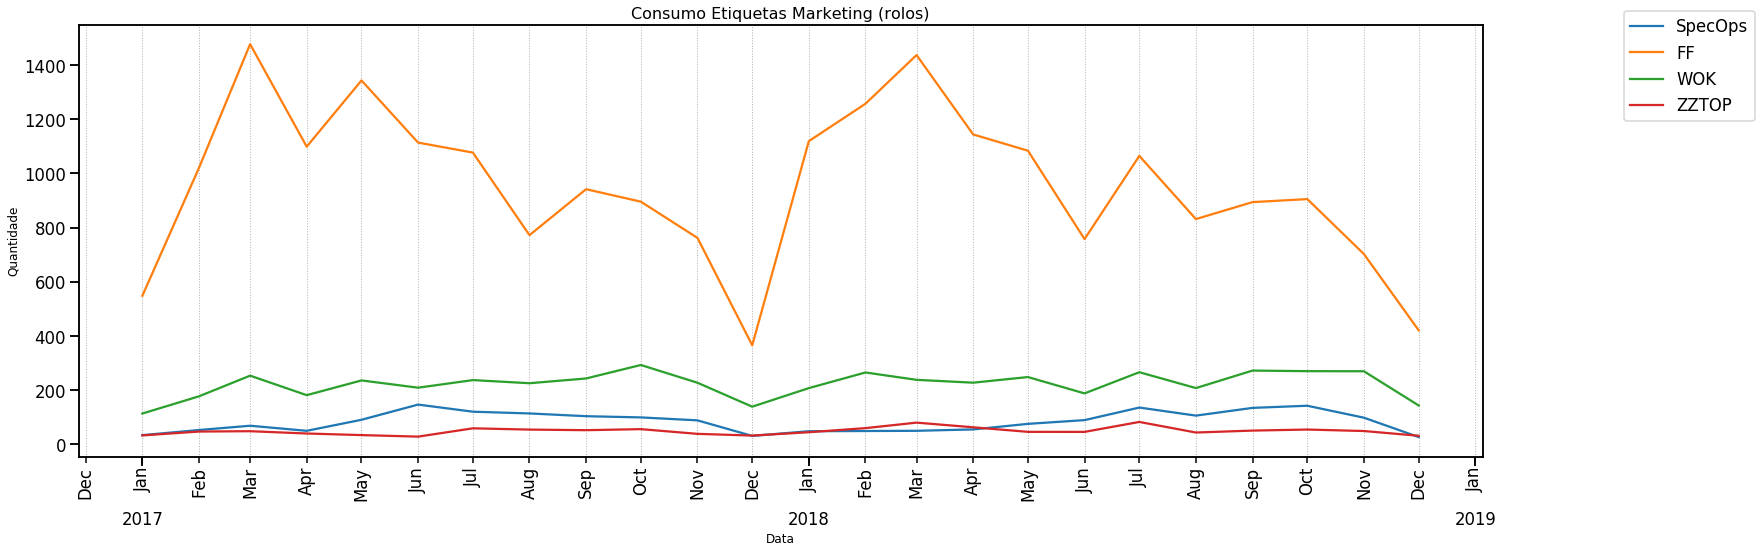

In [28]:
# Total Marketing Label Consumption
fig = plt.figure(figsize=(25.16, 7.95))
ax = plt.axes()

x = total_labels_Marketing.index

SpecOps = total_labels_Marketing['SpecOps']
FF = total_labels_Marketing['FF']
WOK = total_labels_Marketing['WOK']
ZZTOP = total_labels_Marketing['ZZTOP']

ax.plot(x, SpecOps)
ax.plot(x, FF)
ax.plot(x, WOK)
ax.plot(x, ZZTOP)

ax.set_xlabel('Data', fontsize='12')
ax.set_ylabel('Quantidade', fontsize='12')
ax.set_title('Consumo Etiquetas Marketing (rolos)', fontsize='16')
ax.legend(bbox_to_anchor=(1.2, 1.05))

ax.set_xticks(x)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

# Set minor gridlines
ax.xaxis.grid(which="minor", linestyle=':', linewidth=1)

plt.show()

#fig.savefig('etiq.png', bbox_inches='tight')
#files.download('etiq.png') 

### Total Country Label usage

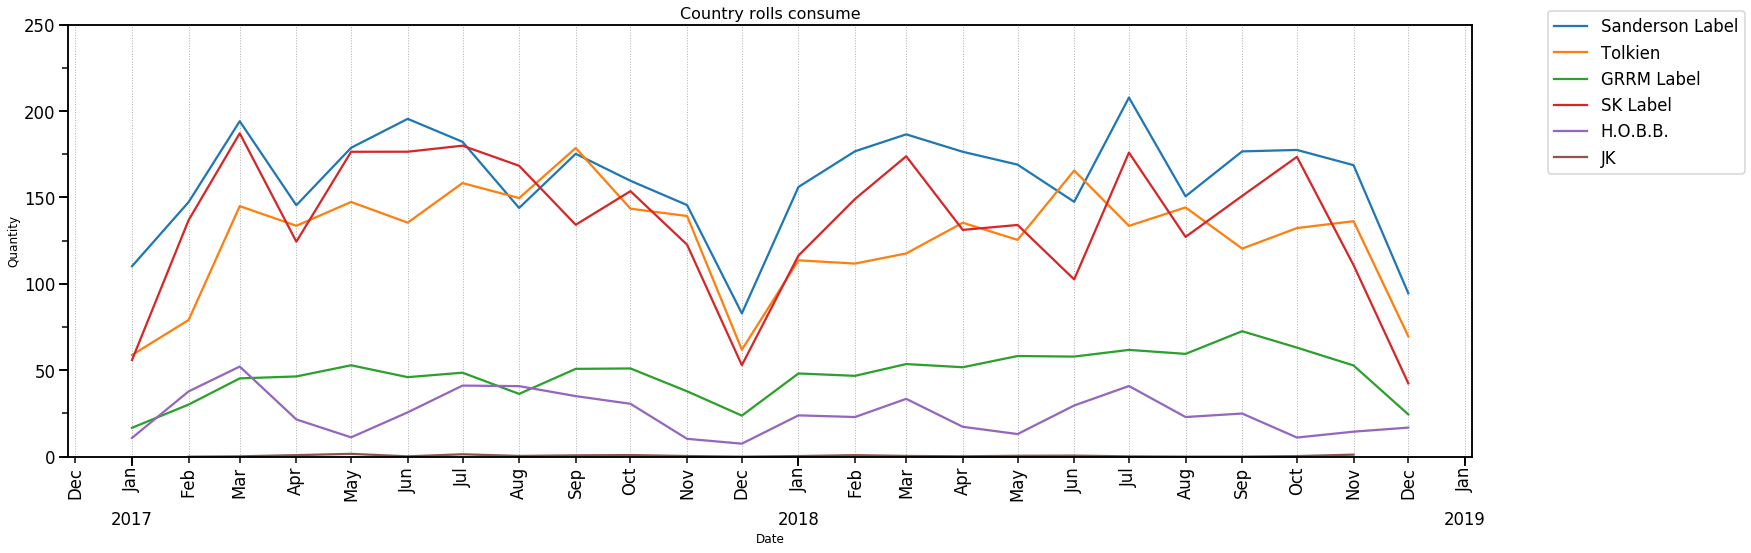

In [30]:
# Total Marketing Label Consumption

fig = plt.figure(figsize=(25.16,7.95))
ax = plt.axes()

x = total_labels_Country.index

Sanderson = total_labels_Country['Sanderson Label']
Tolkien = total_labels_Country['Tolkien']
GRRM = total_labels_Country['GRRM Label']
SK = total_labels_Country['SK Label']
HOBB = total_labels_Country['H.O.B.B.']
JK = total_labels_Country['JK']

ax.plot(x, Sanderson)
ax.plot(x, Tolkien)
ax.plot(x, GRRM)
ax.plot(x, SK)
ax.plot(x, HOBB)
ax.plot(x, JK)

ax.set_xlabel('Date', fontsize='12')
ax.set_ylabel('Quantity', fontsize='12')
ax.set_title('Country rolls consume', fontsize='16')
ax.legend(bbox_to_anchor=(1.2, 1.05))

ax.set_xticks(x)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

# Set minor gridlines
ax.xaxis.grid(which="minor", linestyle=':', linewidth=1)

loc = plticker.MultipleLocator(base=25) # this locator puts ticks at regular intervals
ax.yaxis.set_minor_locator(loc)
ax.set_ylim(0, 250)

# Set minor gridlines
ax.xaxis.grid(which="minor", linestyle=':', linewidth=1)

plt.show()
#fig.savefig('pais.png', bbox_inches='tight')
#files.download('pais.png') 

### Top City usage of last month

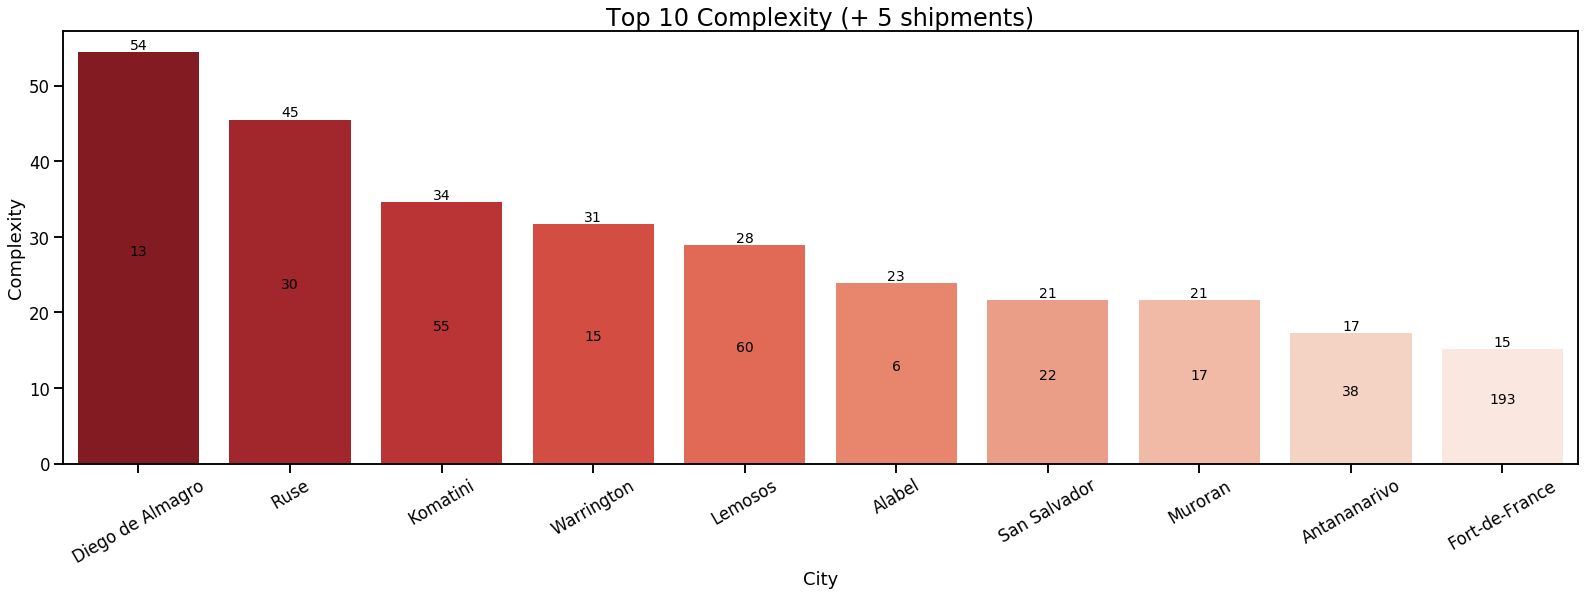

In [38]:
'''
 p.get_x() - get the position
 p.get_width() - get the width of the bar, divide by 2 to center
 p.get_height() - get the height of the bar
 '%d' % int(p.get_height()) - format as number and get the value of 
    the weight of the y axis, as this is the valie of the chart
'''

x = city_complexity['City']
y = city_complexity['Complexity']
y2 = city_complexity['Count']

fig = plt.figure(figsize=(27.16, 7.95))
ax = plt.axes()

sns.barplot(x=x, y=y, ax=ax, palette='Reds_r')
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

values = y2.values
j = 0

ax.set_title('Top 10 Complexity (+ 5 shipments)', fontsize='24')
plt.xticks(rotation=30)

# Add Label values
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=14, color='black', ha='center', va='bottom')

# Add the count of UT
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height()/2, values[j], 
            fontsize=14, color='black', ha='center', va='bottom')
    j += 1

plt.show()

#fig.savefig('complex.png', bbox_inches='tight')
#files.download('complex.png')

In [0]:
'''df2.to_csv('data.csv')
files.download("data.csv")'''


###Total Expedition

(0, 5000000)

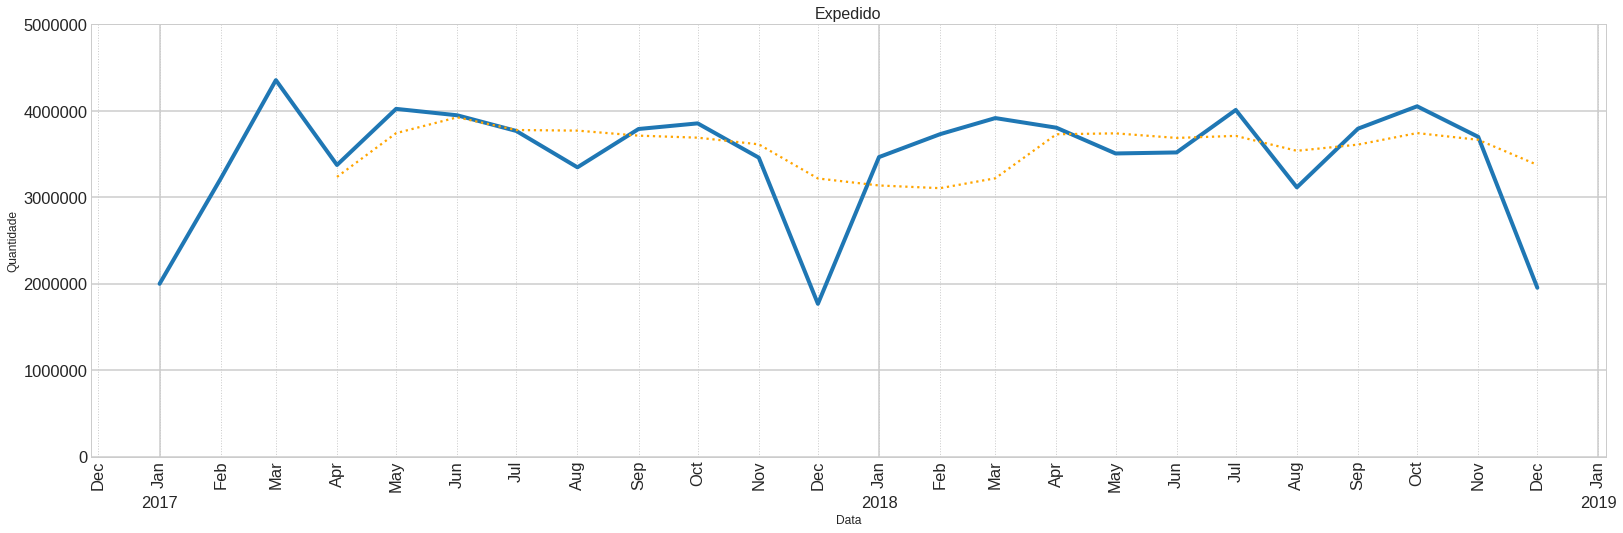

In [44]:
# Try and plot in a different way here
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(27.16, 7.95))
ax = plt.axes()

x = total_products_shipped.index
y = total_products_shipped['Quantity']

ax.plot(x, y, linewidth=4)

#Set the correct axis
ax.set_xticks(x)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

# Trend with moving average
total_products_shipped['MA'] = total_products_shipped['Quantity'].rolling(window=4,center=False).mean()

ax.plot(x, total_products_shipped['MA'], color='Orange', linestyle=':')

# Remove Legend
ax.legend().remove()

# Set minor gridlines
ax.xaxis.grid(which="minor", linestyle=':', linewidth=1)

ax.set_xlabel('Data', fontsize='12')
ax.set_ylabel('Quantidade', fontsize='12')
ax.set_title('Expedido', fontsize='16')

ax.set_ylim(0, 5000000)

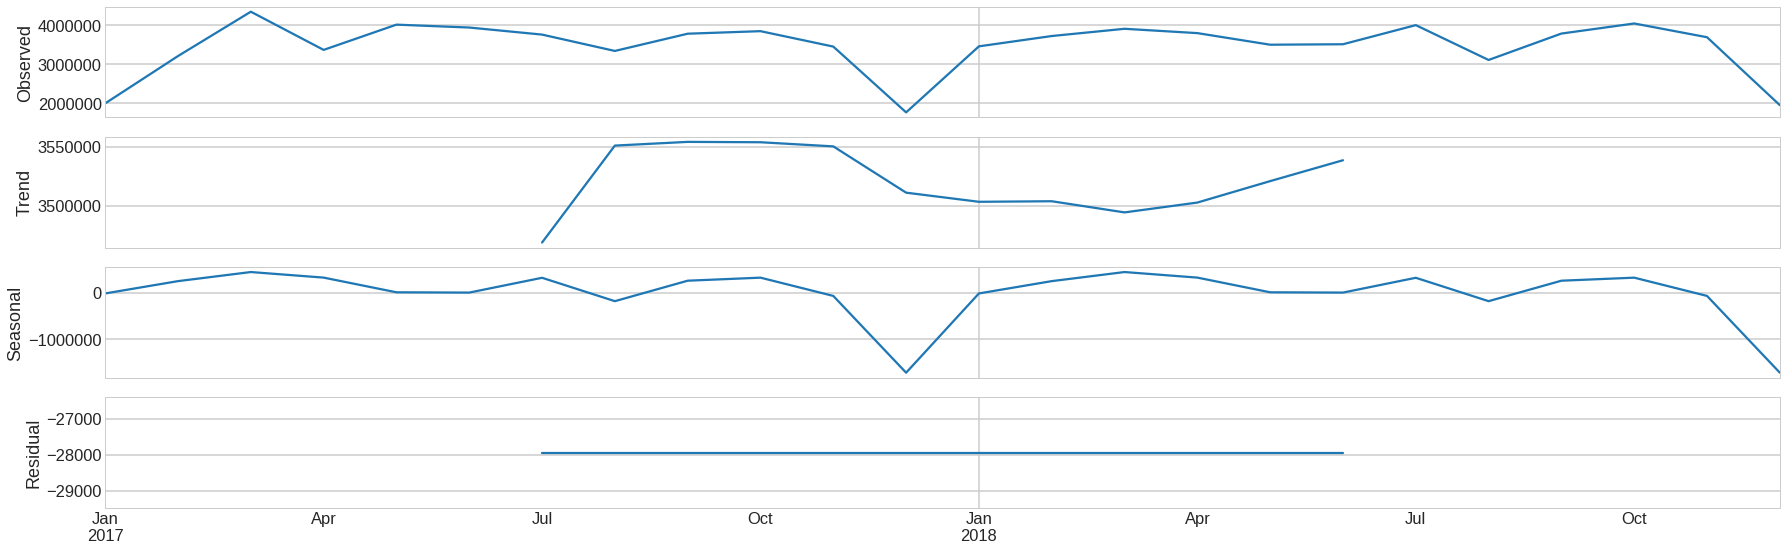

In [47]:
import numpy as np
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 25.16, 8
decomposition = sm.tsa.seasonal_decompose(total_products_shipped['Quantity'], model='additive')
fig = decomposition.plot()
plt.show()

### Data in a map

In [63]:
import plotly.express as px

# Get last month data
m = total_products_shipped_Country.index.max()

fig = px.choropleth(total_products_shipped_Country.loc[m], 
                    locationmode='country names',
                    locations='Country Name', 
                    hover_name='Country Name', color='Quantity',
                    projection='natural earth',
                    color_continuous_scale=px.colors.sequential.YlOrBr,
                    title='Number of quantity exported across the world last month')

fig.show()


In [67]:
fig = px.scatter_geo(total_products_shipped_Country.loc[m],
                     locationmode='country names',
                     locations='Country Name', 
                     color='Continent',
                     hover_name='Country Name', 
                     color_continuous_scale=px.colors.sequential.YlOrBr,
                     size = 'Quantity',
                     projection='natural earth',
                     )

fig.show()